In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [44]:
answers_df = pd.read_csv('raw_data/pilot_data/p4/answers-1720757049161.csv')

# change unix time to date time
answers_df['time'] = pd.to_datetime(answers_df['time'], unit='ms')
answers_df = answers_df.sort_values(by='time')
answers_df['next_time'] = answers_df['time'].shift(-1)
answerkey_df = pd.read_csv('answer-key.csv')

answerkey_df.rename(columns={'answer': 'correctAnswer'}, inplace=True)

mergedAnswers_df = pd.merge(answers_df, answerkey_df, on=['pageName', 'question'], how='left')
mergedAnswers_df['is_correct'] = mergedAnswers_df['answer'] == mergedAnswers_df['correctAnswer']

mergedAnswers_df = mergedAnswers_df.drop(columns=['next_time'])
mergedAnswers_df = mergedAnswers_df.drop(columns=['time_y'])
mergedAnswers_df = mergedAnswers_df[mergedAnswers_df['version'] != 'undefined']

Number of correct answers: 27

Correct answers by version:
version
interactive    13
static         14
Name: score, dtype: int64

Incorrect answers by version:
version
interactive    2
static         1
Name: score, dtype: int64

Percent accuracy by version:
version
interactive    0.866667
static         0.933333
Name: score, dtype: float64


C:\Users\rainy\AppData\Local\Temp\ipykernel_8828\1476577167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df_filtered['time_diff'] = answers_df_filtered['time'].diff().dt.total_seconds()
C:\Users\rainy\AppData\Local\Temp\ipykernel_8828\1476577167.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df_filtered['section'] = answers_df_filtered['pageName'].str[:5]


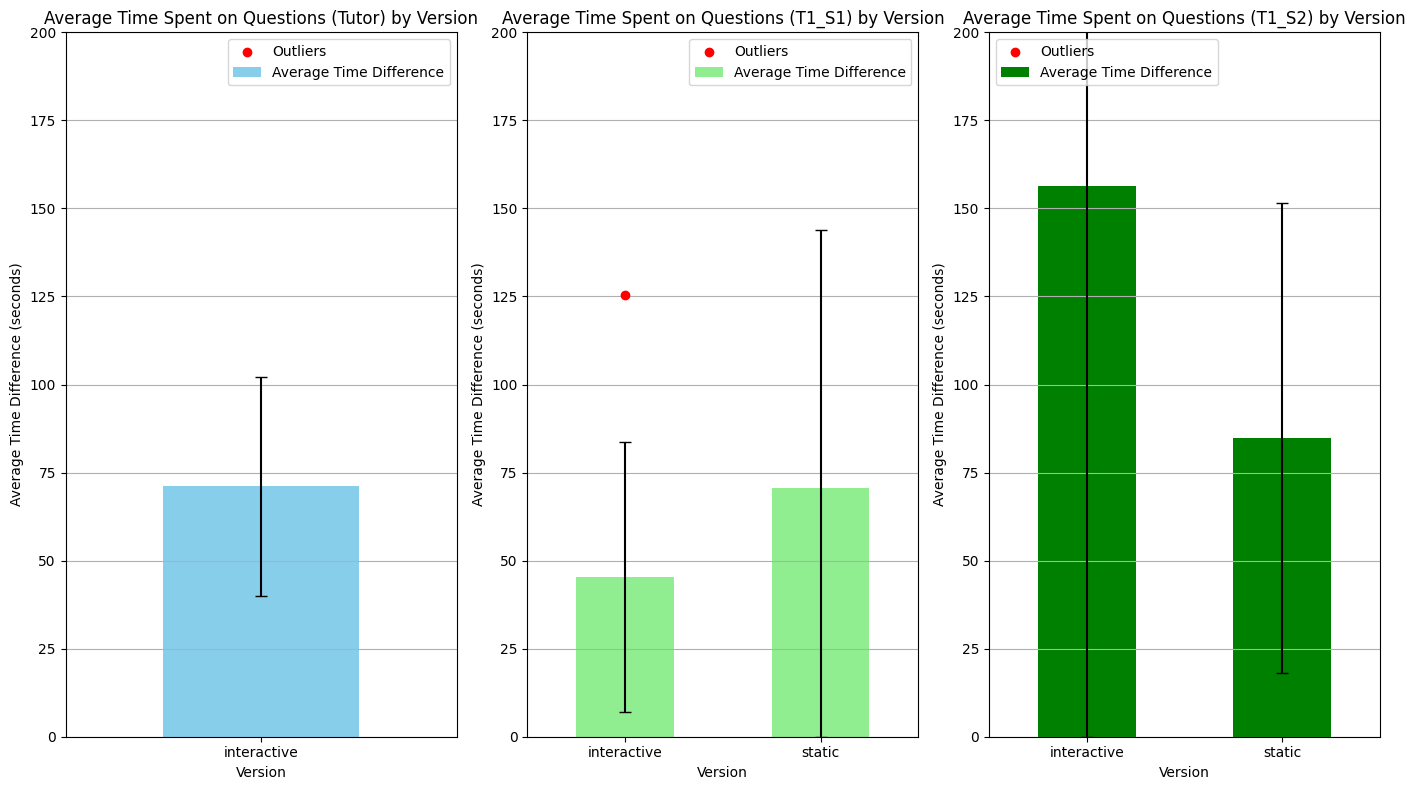

In [55]:
mergedAnswers_df['penalty_bonus'] = 0

# Check the answer for t1_s2_c1 and apply penalty or bonus accordingly
def apply_penalty_bonus(row):
    if row['question'] in ['T1_S2_C1', 'T1_S2_C2']:
        if row['answer'].lower() == 'yes':
            return -3
        elif row['answer'].lower() == 'no':
            return 3
    elif row['question'] in ['T1_S2_IN1', 'T1_S2_IN2']:
        if row['answer'].lower() == 'no':
            return -3
    return 0

# Apply the function to the DataFrame
mergedAnswers_df['penalty_bonus'] = mergedAnswers_df.apply(apply_penalty_bonus, axis=1)

mergedAnswers_df['score'] = mergedAnswers_df['is_correct'].astype(int) + mergedAnswers_df['penalty_bonus']

correct_count = mergedAnswers_df['score'].sum()
print(f"Number of correct answers: {correct_count}")

correct_by_version = mergedAnswers_df.groupby('version')['score'].sum()
print("\nCorrect answers by version:")
print(correct_by_version)

total_by_version = mergedAnswers_df.groupby('version')['score'].count()
incorrect_by_version = total_by_version - correct_by_version
print("\nIncorrect answers by version:")
print(incorrect_by_version)

percent_accuracy = correct_by_version/total_by_version
print("\nPercent accuracy by version:")
print(percent_accuracy)

answers_df_filtered = answers_df[answers_df['version'] != 'undefined']

# Calculate time differences (speed) between consecutive questions
answers_df_filtered['time_diff'] = answers_df_filtered['time'].diff().dt.total_seconds()

answers_df_filtered['section'] = answers_df_filtered['pageName'].str[:5]
grouped = answers_df_filtered.groupby(['section', 'version'])['time_diff']
mean_speed_by_section_version = grouped.mean()
std_speed_by_section_version = grouped.std()

# Calculate the lower and upper error bars
lower_error = mean_speed_by_section_version - std_speed_by_section_version
upper_error = mean_speed_by_section_version + std_speed_by_section_version

# Ensure the lower error bar does not go below zero
lower_error = np.maximum(lower_error, 0)

# Identify outliers using IQR method
Q1 = grouped.quantile(0.25)
Q3 = grouped.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = {section_version: answers_df_filtered[(answers_df_filtered['section'] == section_version[0]) & 
                                                 (answers_df_filtered['version'] == section_version[1]) & 
                                                 ((answers_df_filtered['time_diff'] < lower_bound[section_version]) | 
                                                  (answers_df_filtered['time_diff'] > upper_bound[section_version]))]['time_diff']
            for section_version in mean_speed_by_section_version.index}

# Plotting
plt.figure(figsize=(14, 8))

sections = answers_df_filtered['section'].unique()
colors = ['skyblue', 'lightgreen', 'green']

for i, section in enumerate(sections):
    ax = plt.subplot(1, 3, i + 1)
    
    section_data = mean_speed_by_section_version[section]
    section_lower_error = lower_error[section]
    section_upper_error = upper_error[section]
    
    section_data.plot(kind='bar', yerr=[section_data - section_lower_error, section_upper_error - section_data], 
                      capsize=4, color=colors[i], ax=ax, label='Average Time Difference')
    
    for version, outlier_values in outliers.items():
        if version[0] == section:
            x = section_data.index.get_loc(version[1])
            ax.scatter([x]*len(outlier_values), outlier_values, color='red', zorder=5, label='Outliers' if x == 0 else "")
    
    ax.set_title(f'Average Time Spent on Questions ({section}) by Version')
    ax.set_xlabel('Version')
    ax.set_ylabel('Average Time Difference (seconds)')
    ax.set_xticks(range(len(section_data.index)))
    ax.set_xticklabels(section_data.index, rotation=0)
    plt.ylim(0, 200)
    ax.grid(axis='y')
    ax.legend()

plt.tight_layout()
plt.show()

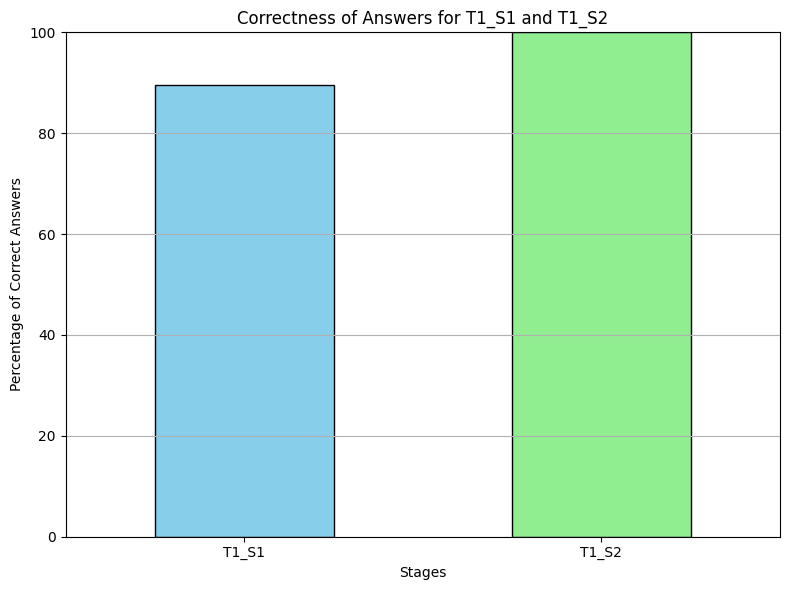

In [48]:
t1_s1_df = mergedAnswers_df[mergedAnswers_df['pageName'].str.startswith('T1_S1')]
t1_s2_df = mergedAnswers_df[mergedAnswers_df['pageName'].str.startswith('T1_S2')]

# Calculate the correctness for T1_S1 and T1_S2
correct_by_t1_s1 = t1_s1_df['is_correct'].sum()
total_by_t1_s1 = t1_s1_df['is_correct'].count()
correct_by_t1_s2 = t1_s2_df['is_correct'].sum()
total_by_t1_s2 = t1_s2_df['is_correct'].count()

# Create a DataFrame for plotting
correctness_df = pd.DataFrame({
    'Correct': [correct_by_t1_s1, correct_by_t1_s2],
    'Total': [total_by_t1_s1, total_by_t1_s2]
}, index=['T1_S1', 'T1_S2'])

# Calculate the percentage of correct answers
correctness_df['Percentage'] = (correctness_df['Correct'] / correctness_df['Total']) * 100

# Plotting the results
plt.figure(figsize=(8, 6))
correctness_df['Percentage'].plot(kind='bar', color=['skyblue', 'lightgreen'], edgecolor='black')
plt.title('Correctness of Answers for T1_S1 and T1_S2')
plt.xlabel('Stages')
plt.ylabel('Percentage of Correct Answers')
plt.xticks(rotation=0)
plt.ylim(0, 100)  # Ensuring the y-axis goes from 0 to 100%
plt.grid(axis='y')
plt.tight_layout()
plt.show()